In [1]:
import os
import numpy as np
from scipy.stats import median_abs_deviation as mad
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core.plot import plot_strips
from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

# overwrite or not
OVERWRITE = False

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
# filter frames with continuum emission in the fibers
target_frames = frames_table.query("(imagetyp=='arc' & ldls & not (argon|neon|xenon|hgne|krypton)) | imagetyp=='object'")
target_frames = target_frames.sort_values("camera").reset_index(drop=True)
target_frames

imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls  \
0     object  sp1  60041     b1  00000679     30.0  False  False  False   
1     object  sp1  60040     b1  00000607    900.0  False  False  False   
2     object  sp1  60039     b1  00000509    120.0  False  False  False   
3     object  sp1  60040     b1  00000641     60.0  False  False  False   
4     object  sp1  60010     b1  00000174    180.0  False  False  False   
..       ...  ...    ...    ...       ...      ...    ...    ...    ...   
676   object  sp3  60039     z3  00000567     15.0  False  False   True   
677   object  sp3  60039     z3  00000509    120.0  False  False  False   
678   object  sp3  60039     z3  00000590    180.0  False  False   True   
679   object  sp3  60039     z3  00000504    120.0  False  False  False   
680   object  sp3  60039     z3  00000503      5.0  False  False  False   

      hgne  xenon  krypton                                               path  
0    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
1    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
2    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
3    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
4    False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
..     ...    ...      ...                                                ...  
676  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
677  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
678  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
679  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  
680  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examp...  

[681 rows x 13 columns]

MJD:   0%|          | 0/5 [00:00<?, ?mjd/s]

camera:   0%|          | 0/3 [00:00<?, ?camera/s]

frame:   0%|          | 0/30 [00:00<?, ?frame/s]

frame:   0%|          | 0/30 [00:00<?, ?frame/s]

frame:   0%|          | 0/30 [00:00<?, ?frame/s]

camera:   0%|          | 0/3 [00:00<?, ?camera/s]

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

frame:   0%|          | 0/31 [00:00<?, ?frame/s]

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/47 [00:00<?, ?frame/s]

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

frame:   0%|          | 0/15 [00:00<?, ?frame/s]

frame:   0%|          | 0/33 [00:00<?, ?frame/s]

camera:   0%|          | 0/6 [00:00<?, ?camera/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

[WARNING]: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`. (RuntimeWarning)
[WARNING]: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`. (RuntimeWarning)


frame:   0%|          | 0/28 [00:00<?, ?frame/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

frame:   0%|          | 0/28 [00:00<?, ?frame/s]

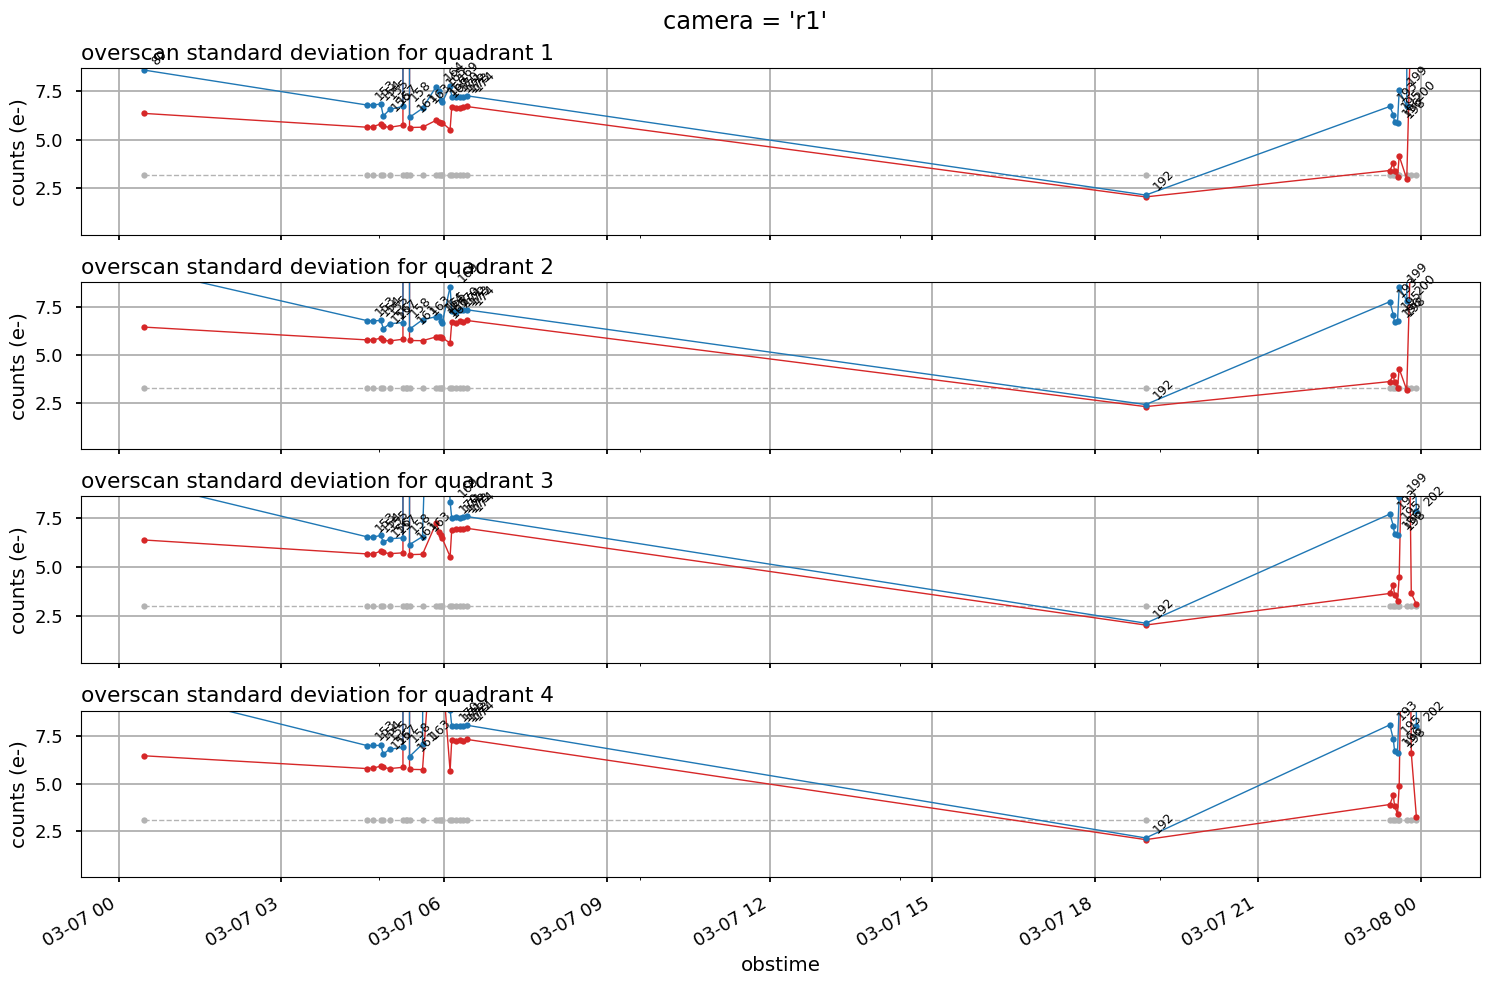

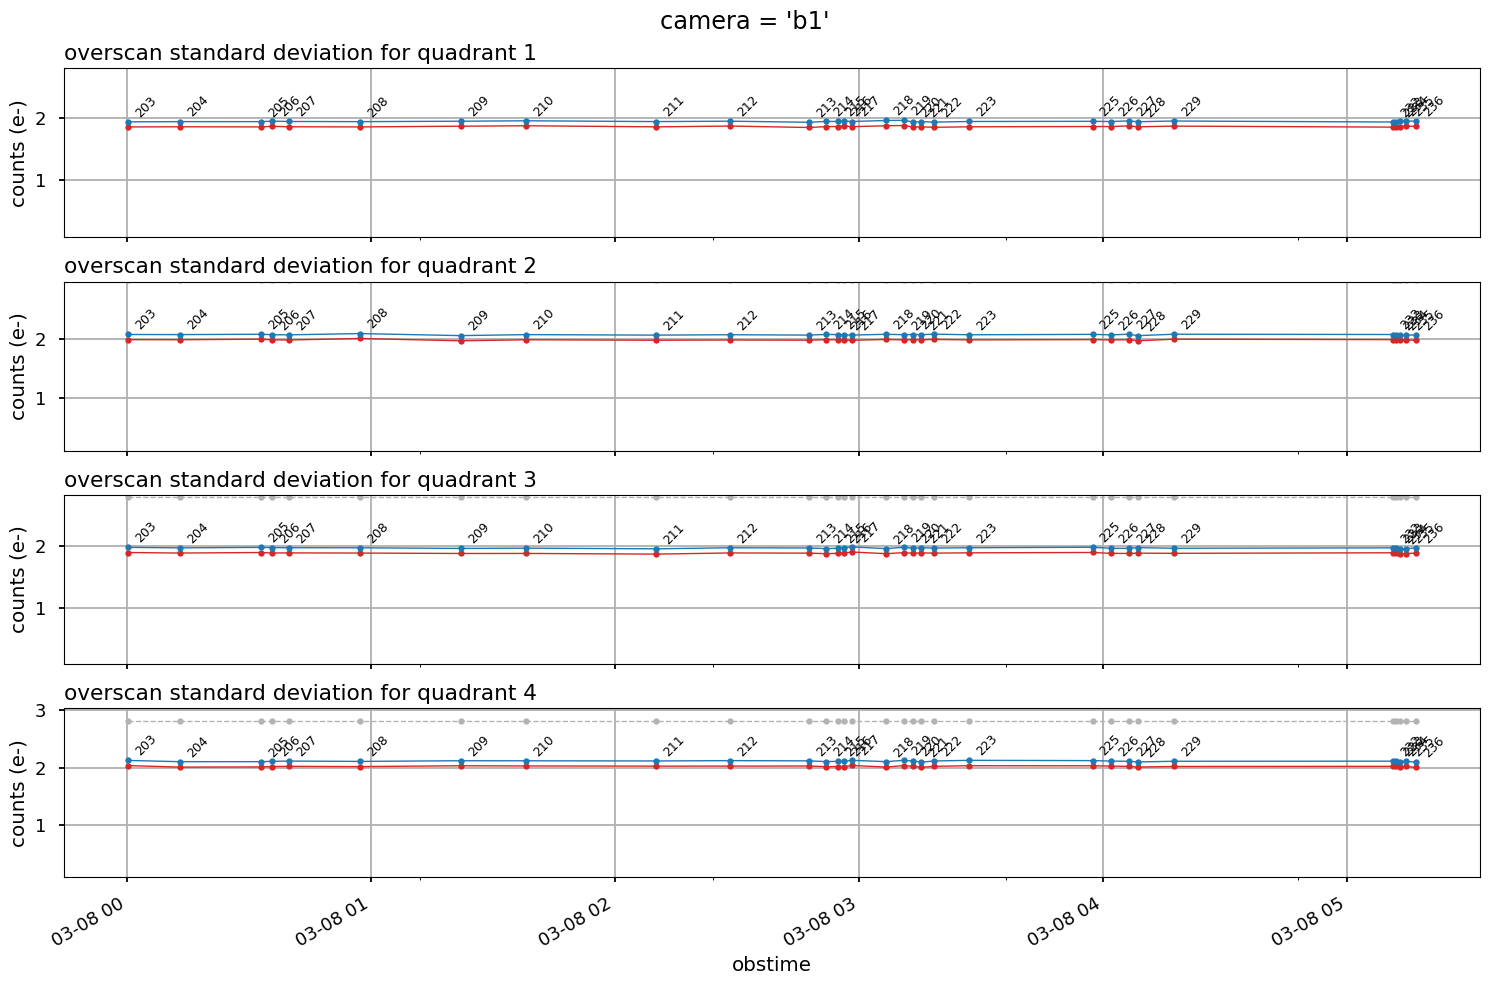

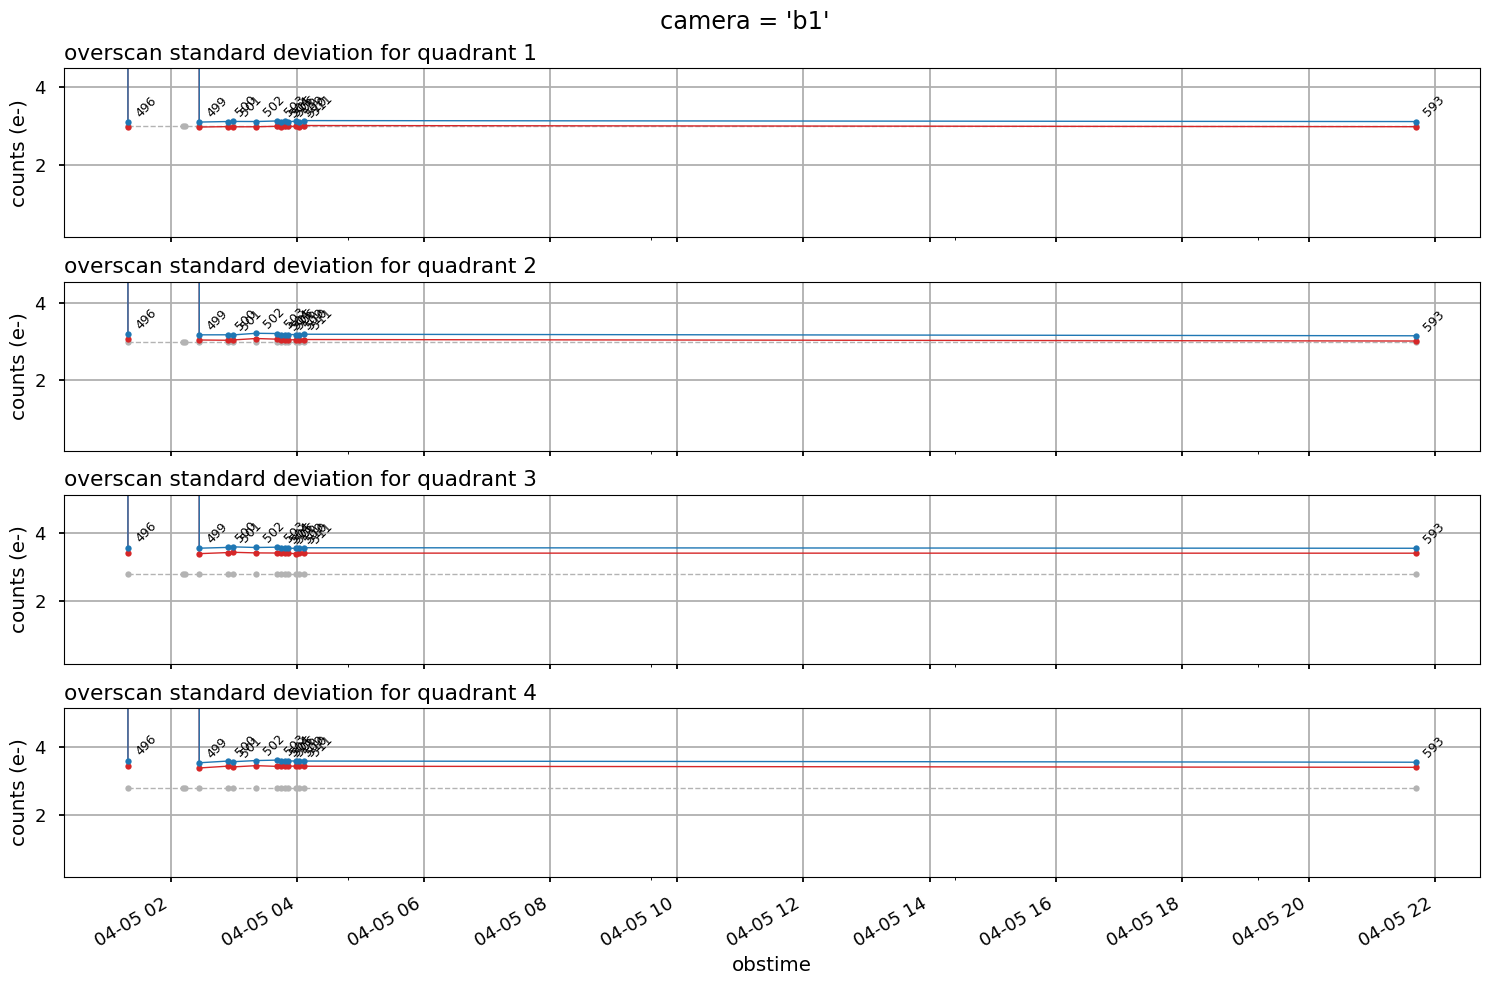

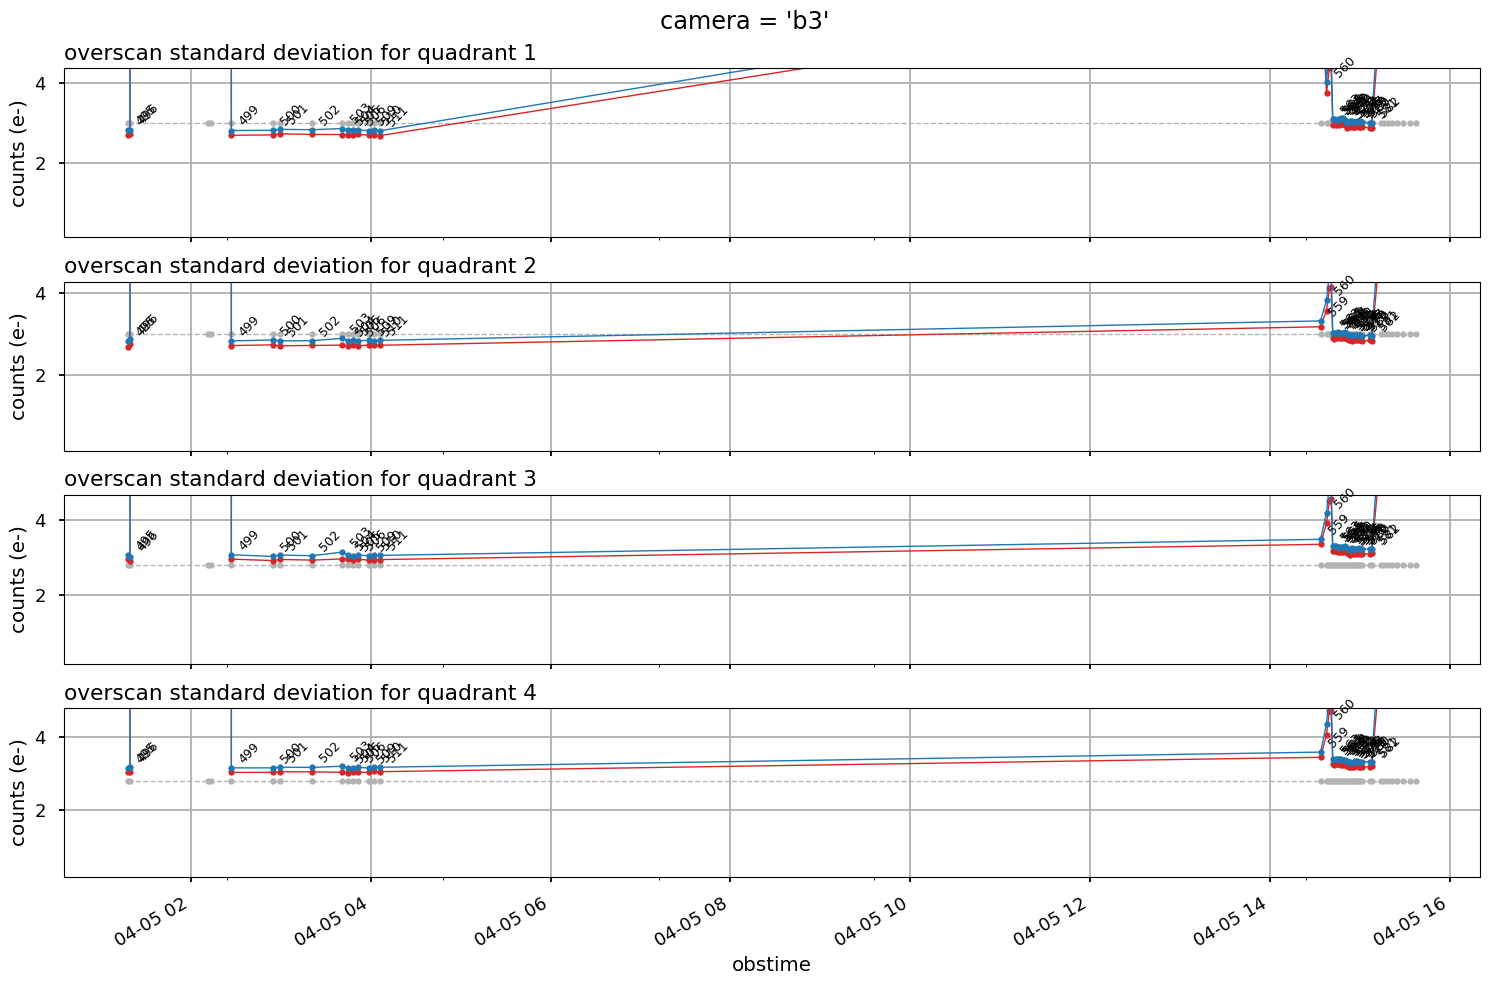

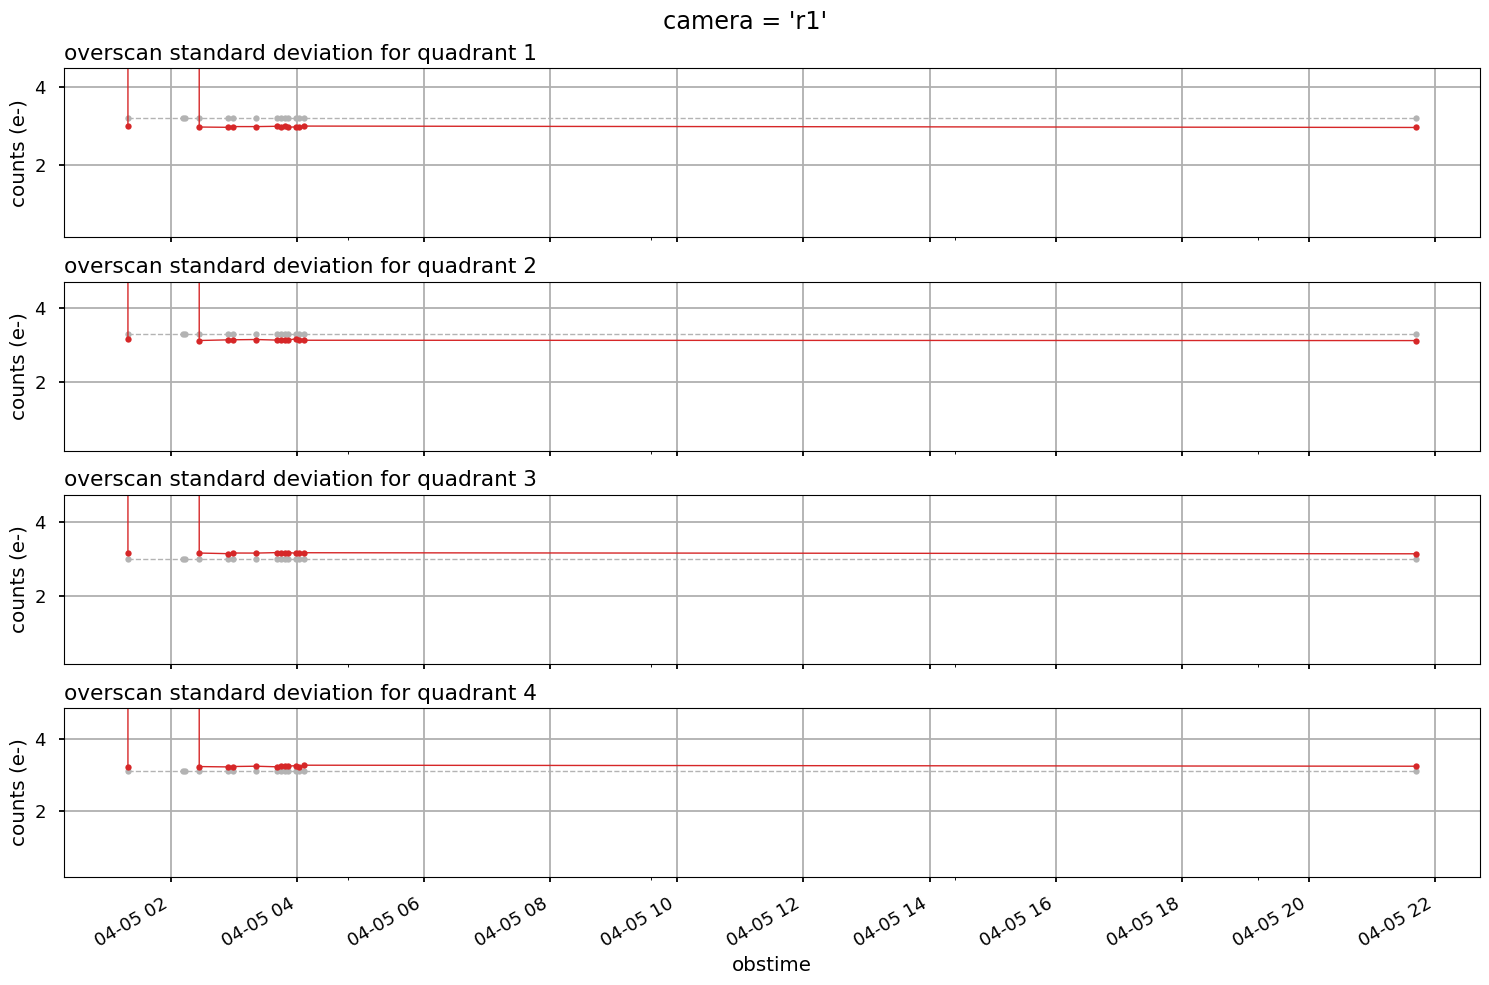

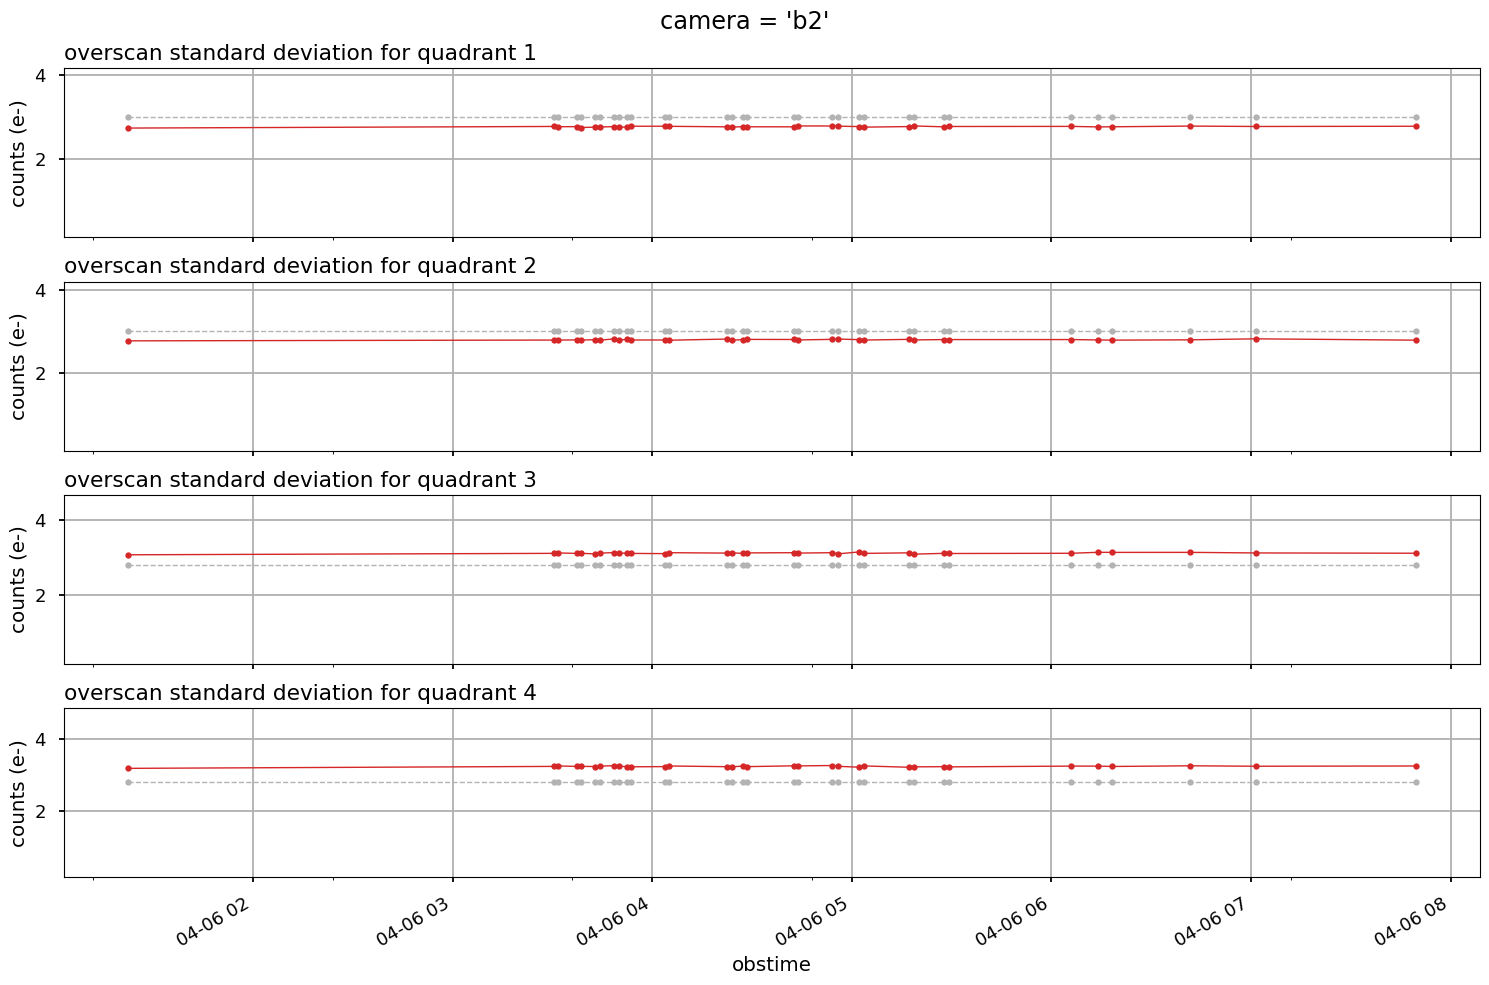

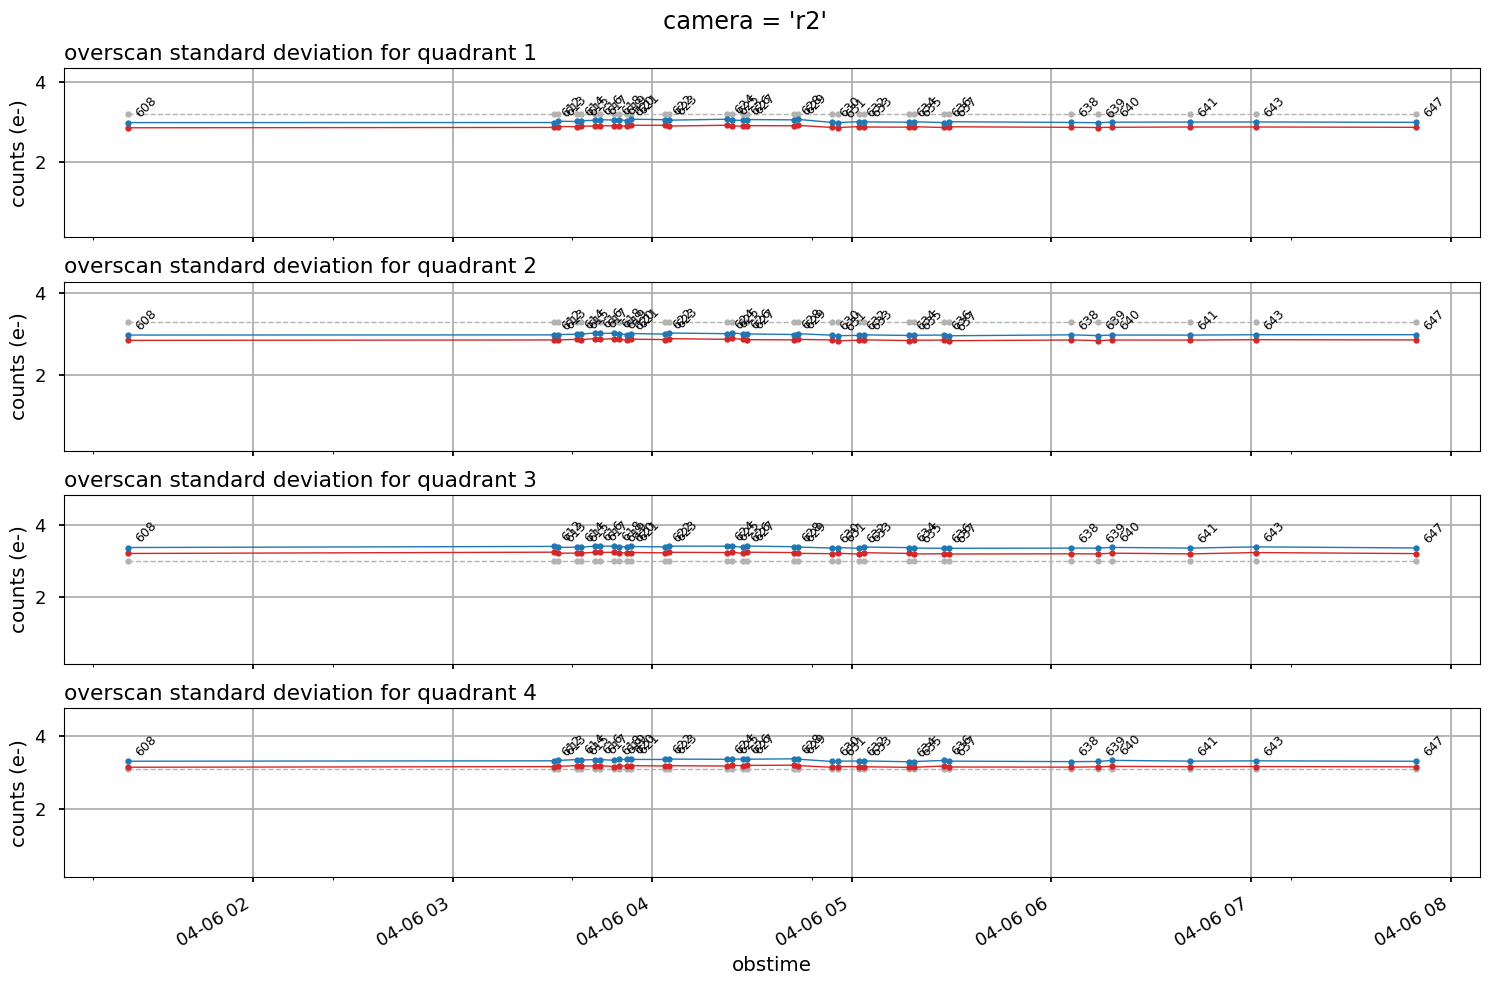

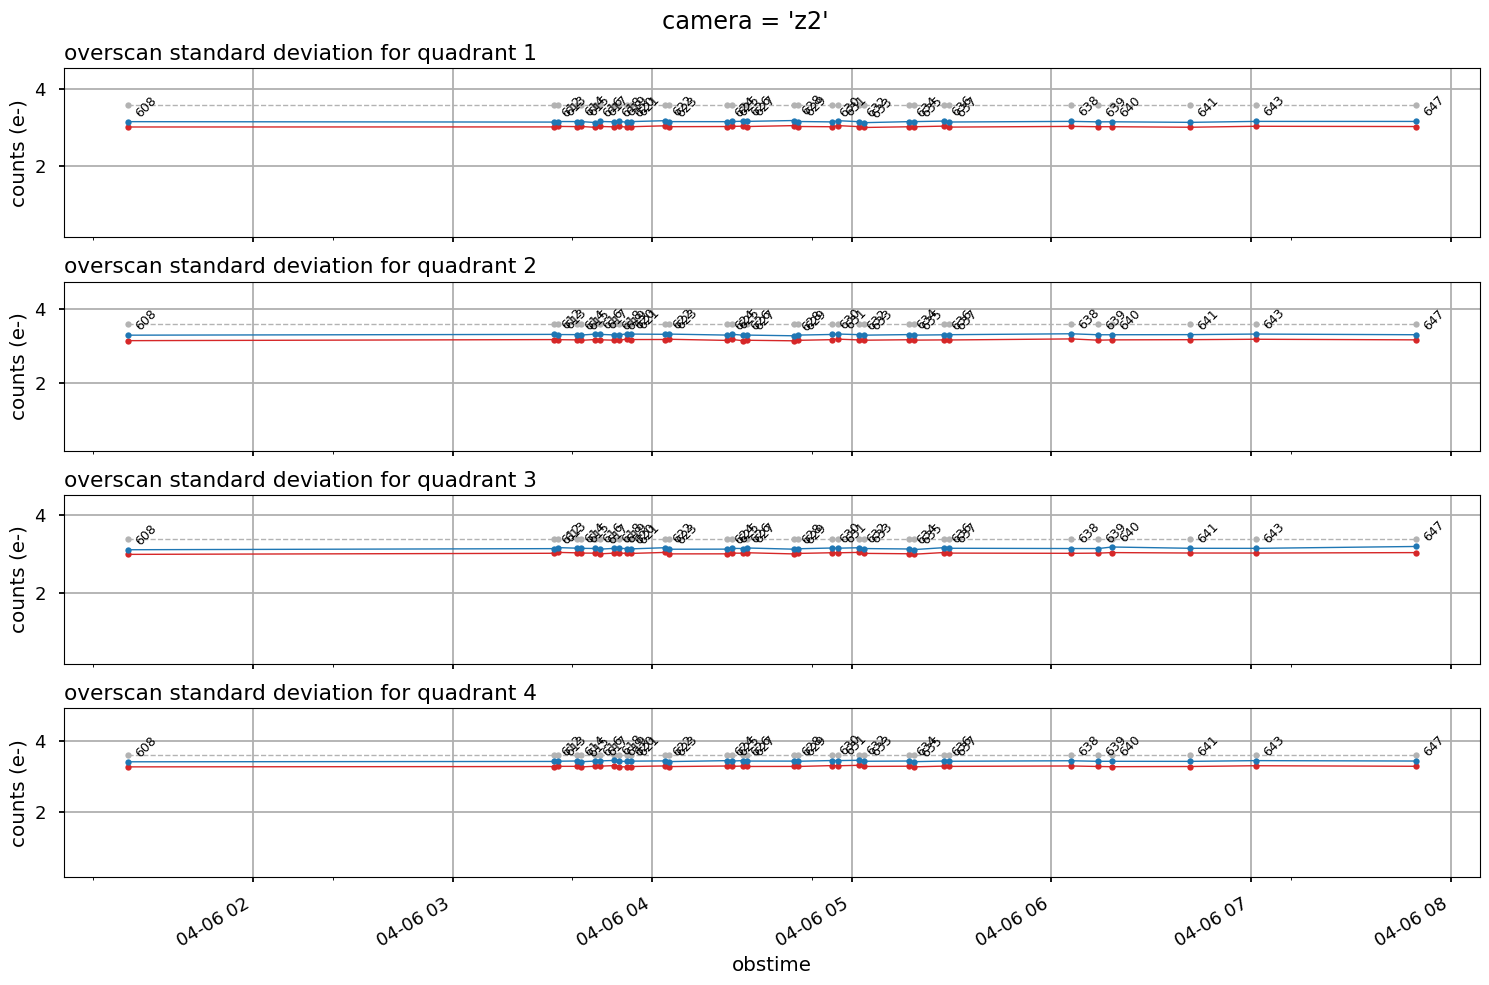

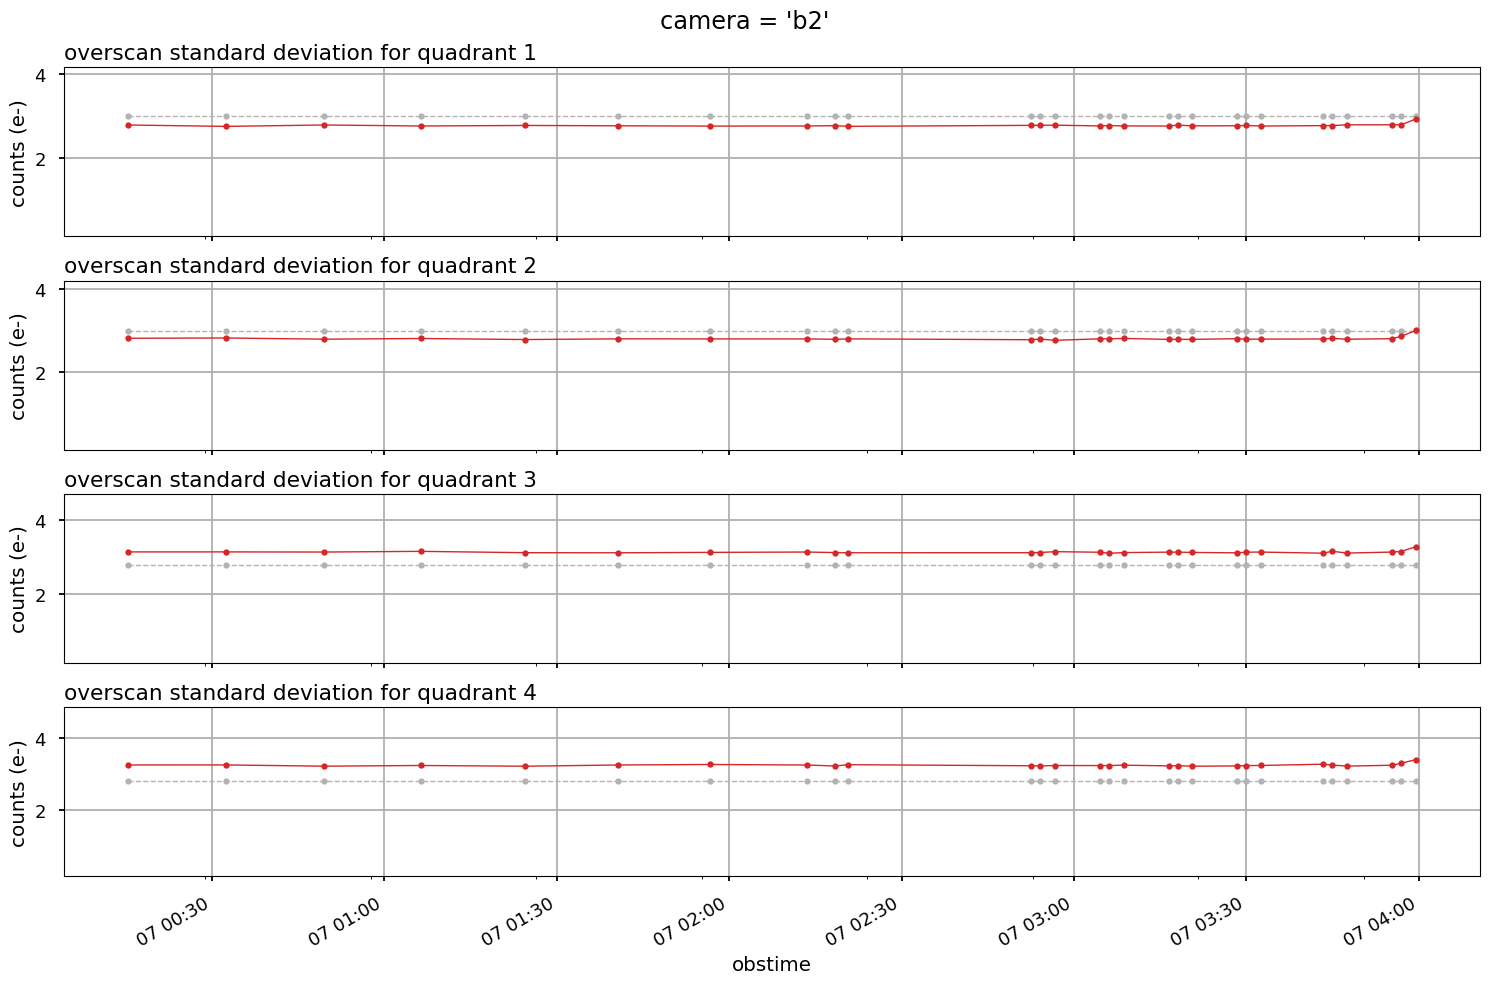

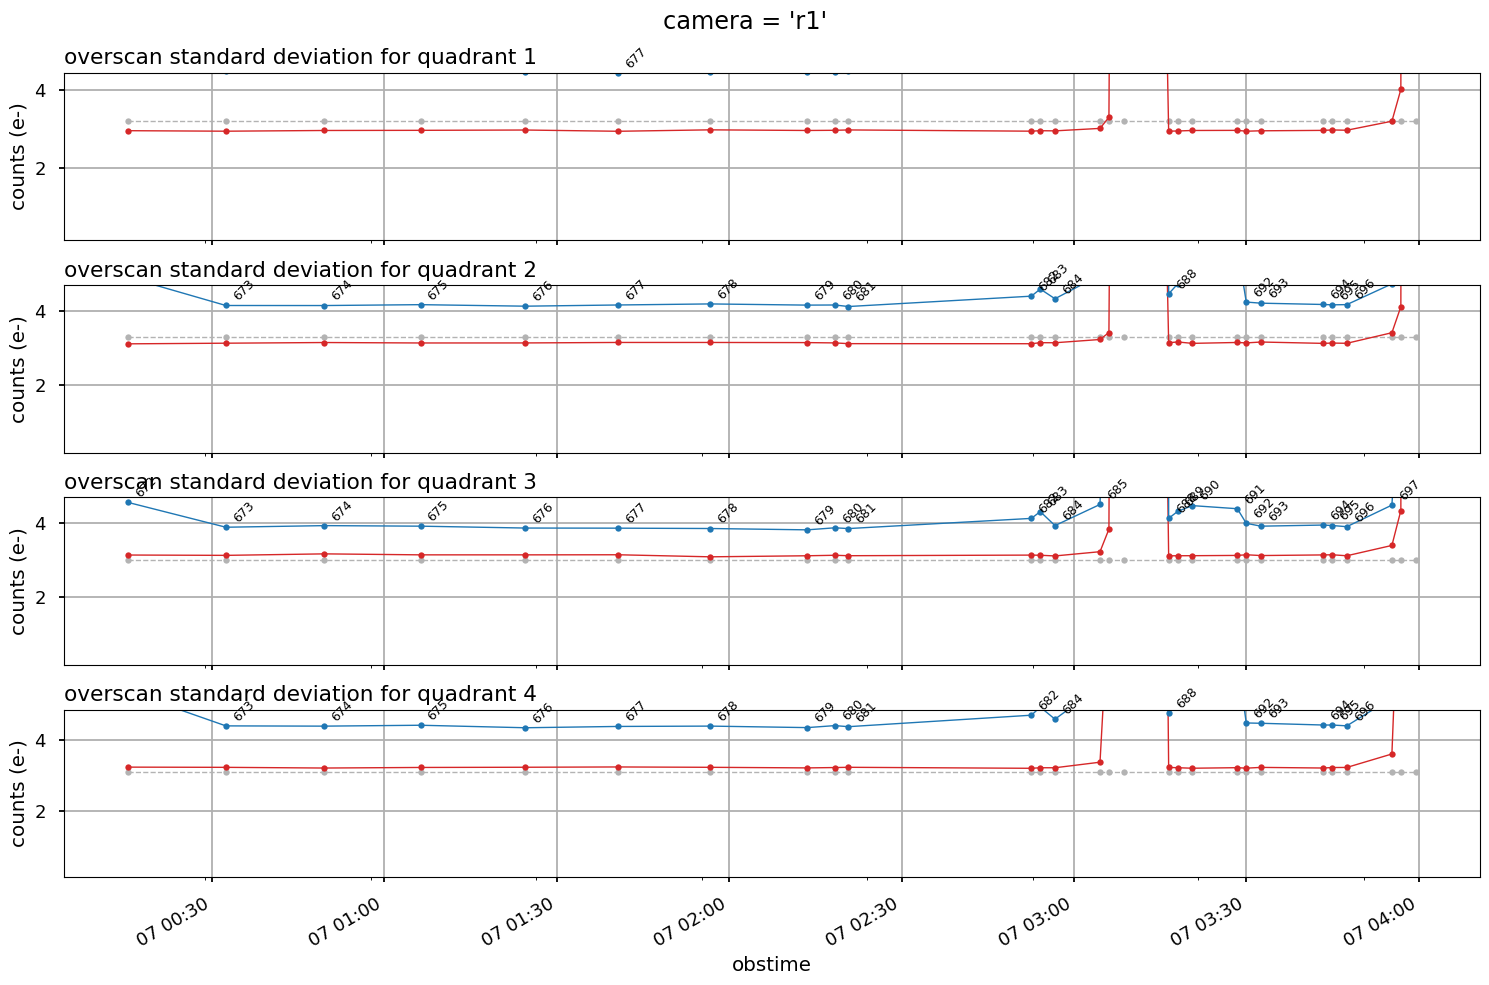

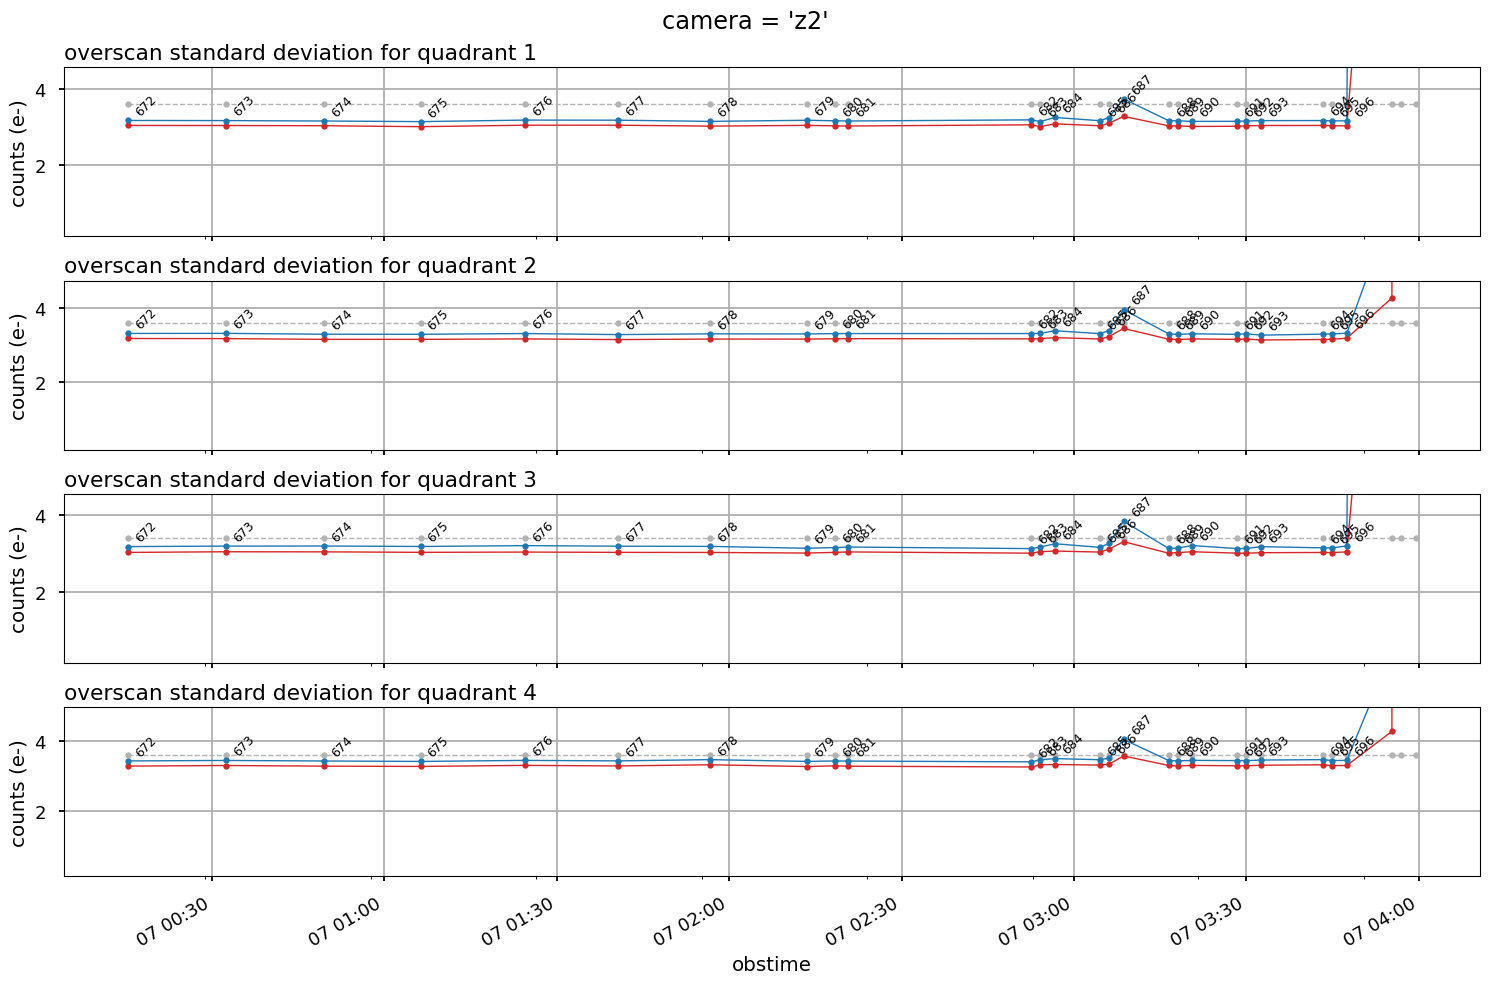

In [5]:
mjds = [60010, 60011, 60039, 60040, 60041]

for mjd in tqdm(mjds, desc="MJD", unit="mjd"):
    frame_groups = target_frames.loc[target_frames.mjd==mjd].groupby("camera")

    for camera in tqdm(frame_groups.groups, desc="camera", unit="camera"):
        frames_camera = frame_groups.get_group(camera).sort_values("mjd")
        table = pd.DataFrame(index=frames_camera.index, columns=[
            "frame",
            "exposure",
            "obstime",
            "exptime",
            "cnt_med1",
            "cnt_med2",
            "cnt_med3",
            "cnt_med4",
            "cnt_std1",
            "cnt_std2",
            "cnt_std3",
            "cnt_std4",
            "cnt_mad1",
            "cnt_mad2",
            "cnt_mad3",
            "cnt_mad4",
            "cnt_mst1",
            "cnt_mst2",
            "cnt_mst3",
            "cnt_mst4",
            "rdnoise1",
            "rdnoise2",
            "rdnoise3",
            "rdnoise4",
        ])
        for i, frame in tqdm(frames_camera.iterrows(), total=len(frames_camera), desc="frame", unit="frame"):
            img = image.loadImage(frame.path)

            # extract header metadata
            frame_name = img._header["FILENAME"].replace(".fits.gz", "")
            table.loc[i, "frame"] = frame_name
            table.loc[i, "exposure"] = img._header["EXPOSURE"]
            table.loc[i, "obstime"] = img._header["OBSTIME"]
            table.loc[i, "exptime"] = img._header["EXPTIME"]

            # prepare overscan strip plots
            fig_strips, axs_strips = plt.subplots(4, 1, figsize=(15,10), sharex=True, sharey=False)
            fig_strips.suptitle(f"{frame_name = }", size="xx-large")
            
            # compute statistics & plot quadrant strips
            for j in range(4):
                quad = img.getSection(imageMethod.DEFAULT_BIASSEC[j])
                quad *= img._header[f"GAIN{j+1}"]
                table.loc[i, f"cnt_med{j+1}"] = np.median(quad._data)
                table.loc[i, f"cnt_std{j+1}"] = np.std(quad._data)
                table.loc[i, f"cnt_mad{j+1}"] = mad(quad._data, axis=None)
                table.loc[i, f"cnt_mst{j+1}"] = np.mean(np.std(quad._data, axis=1))
                table.loc[i, f"rdnoise{j+1}"] = img._header[f"RDNOISE{j+1}"]

                strip_med = np.median(quad._data, axis=1)
                strip_mad = mad(quad._data, axis=1)
                strip_pix = np.arange(strip_med.size)
                # plot strip
                axs_strips[j].axhline(table.loc[i, f"cnt_med{j+1}"]+table.loc[i, f"cnt_mad{j+1}"], ls="-", lw=1, color="tab:blue")
                axs_strips[j].axhline(table.loc[i, f"cnt_med{j+1}"], ls="-", lw=1, color="0.2")
                axs_strips[j].axhline(table.loc[i, f"cnt_med{j+1}"]+img._header[f"RDNOISE{j+1}"], ls="--", lw=1, color="0.2")
                axs_strips[j].fill_between(
                    strip_pix,
                    strip_med - strip_mad,
                    strip_med + strip_mad,
                    step="pre",
                    lw=0,
                    fc="tab:blue",
                    alpha=0.5,
                )
                axs_strips[j].step(strip_pix, strip_med, color="tab:red", lw=1)
                
                axs_strips[j].set_ylim(
                    (table.loc[i, f"cnt_med{j+1}"]-img._header[f"RDNOISE{j+1}"])*0.999,
                    (table.loc[i, f"cnt_med{j+1}"]+img._header[f"RDNOISE{j+1}"])*1.001
                )
                axs_strips[j].set_ylabel("counts (e-)")
                axs_strips[j].set_title(f"overscan strips for quadrant {j+1}", loc="left")

            # save strips figure
            axs_strips[-1].set_xlabel("Y (pixel)")
            fig_strips.tight_layout()
            fig_strips.savefig(f"qa_overscan/{mjd}-{frame_name}_os.png", bbox_inches="tight")
            plt.close(fig=fig_strips)

        # further processing of timeseries
        table.obstime = pd.to_datetime(table.obstime)
        table.set_index("obstime", inplace=True)
        table.sort_index(inplace=True)
        # print(table.to_string())

        # prepare overscan timeseries plot
        fig_ts, axs_ts = plt.subplots(4, 1, figsize=(15,10), sharex=True, sharey=False)
        fig_ts.suptitle(f"{camera = }", size="xx-large")

        # plot overscan timeseries
        for i in range(4):
            column = f"cnt_std{i+1}"
            table[f"rdnoise{i+1}"].plot(kind="line", ax=axs_ts[i], style=".--", lw=1, color="0.7")
            table[f"cnt_mst{i+1}"].plot(kind="line", ax=axs_ts[i], style=".-", lw=1, color="tab:red")
            # table[f"cnt_mad{i+1}"].plot(kind="line", ax=axs_ts[i], style=".--", lw=1, color="tab:red")
            table[column].plot(kind="line", ax=axs_ts[i], style=".-", lw=1, color="tab:blue")

            axs_ts[i].set_ylim(table[f"cnt_mst{i+1}"].min()*0.05, table[f"cnt_mst{i+1}"].median()*1.50)
            axs_ts[i].set_ylabel("counts (e-)")
            axs_ts[i].set_title(f"overscan standard deviation for quadrant {i+1}", loc="left")
            axs_ts[i].grid(True)

            for x, row in table.iterrows():
                axs_ts[i].annotate(row.exposure, (x, row[column]), xytext=(5, 5), textcoords="offset pixels", rotation=45, size=9)

        fig_ts.tight_layout()
        fig_ts.savefig(f"qa_overscan/{mjd}-{camera}_os.pdf", bbox_inches="tight")
        # plt.close(fig=fig_ts)